# issues

In [1]:
import numpy as np
import pandas as pd

from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import dextra.dna.core as C
import dextra.dna.commons as P

Using local environment.


In [3]:
spark = P.config.spark

pd.set_option('display.max_colwidth', 200)

sns.set()

## Reading Trusted Dataset

In [4]:
DATA_FILE = P.config.lakes.refined + '/issues.parquet'

In [5]:
x = C.io.stream.read(DATA_FILE)

x.limit(5).toPandas()

,complaint_id,consumer_message,customer_name,date_received,disputed,issue,product,resolution,state,sub_issue,sub_product,tags,timely_response,via,zip_code,ingested_at,tags_trusted_labels,tags_split,text_cleaned,committed_at
0,0052ac552c28,Hello My name is XXXX XXXX and I have a XXXX XXXX XXXX XXXX through Santander Consumer USA. I got the truck back in XXXX and had some financial hardship when my got sick and had to stop working. T...,26d89fd7bd44,2017-01-30,False,Problems when you are unable to pay,Consumer Loan,Closed with explanation,GA,None,Vehicle loan,None,True,Web,300XX,2020-12-08 18:59:37.904553,False,test,hello my name is xxxx xxxx and i have a xxxx xxxx xxxx xxxx through santander consumer usa i got the truck back in xxxx and had some financial hardship when my got sick and had to stop working the...,2020-12-08 19:01:22.031471
1,00a844d52aec,I have written several letters to the creditor ; XXXX and to TransUnion disputing the validity of the information that I found on my credit report. The first dispute letter was sent on XXXX XXXX d...,89dbbe6ad0b5,2016-11-11,True,Credit reporting company's investigation,Credit reporting,Closed with explanation,OH,Investigation took too long,None,None,True,Web,440XX,2020-12-08 18:59:37.904553,False,train,i have written several letters to the creditor xxxx and to transunion disputing the validity of the information that i found on my credit report the first dispute letter was sent on xxxx xxxx disp...,2020-12-08 19:01:22.031471
2,00ae385f4af9,This agency is reporting an account on my redit profile which does not belong to me,321a61586171,2016-10-27,False,Other,Credit card,Closed with explanation,IL,None,None,None,False,Web,604XX,2020-12-08 18:59:37.904553,False,train,this agency is reporting an account on my redit profile which does not belong to me,2020-12-08 19:01:22.031471
3,00da7e528dac,"In XX/XX/XXXX or XX/XX/XXXX, I was contacted regarding help with forgiveness on federal student loans. A gentleman named XXXX working for Integrity Group, Inc.spoke with me regarding the process. ...",f11c4528f211,2017-08-30,None,Fraud or scam,"Money transfer, virtual currency, or money service",Untimely response,PA,None,Domestic (US) money transfer,Older American,False,Web,160XX,2020-12-08 18:59:37.904553,False,train,in xx xx xxxx or xx xx xxxx i was contacted regarding help with forgiveness on federal student loans a gentleman named xxxx working for integrity group inc spoke with me regarding the process he e...,2020-12-08 19:01:22.031471
4,010554da4e3a,"In my previous complaint Equifax states "" Equifax has reviewed your complaint and its records regarding your dispute. Please be advised XXXX XXXX XXXX and/or XXXX XXXX XXXX are not reporting on th...",3fb5aa9ff928,2016-01-06,False,Incorrect information on credit report,Credit reporting,Closed with explanation,CA,Reinserted previously deleted info,None,None,True,Web,913XX,2020-12-08 18:59:37.904553,False,test,in my previous complaint equifax states equifax has reviewed your complaint and its records regarding your dispute please be advised xxxx xxxx xxxx and or xxxx xxxx xxxx are not reporting on the e...,2020-12-08 19:01:22.031471


## Issues

In [6]:
issues_s = (
    x.groupBy('issue')
     .count()
     .orderBy(F.desc('count'))
     .limit(10)
     .toPandas())

issues_s

,issue,count
0,Incorrect information on credit report,21220
1,Cont'd attempts collect debt not owed,17447
2,"Loan servicing, payments, escrow account",14727
3,"Loan modification,collection,foreclosure",10791
4,Dealing with my lender or servicer,7910
5,Disclosure verification of debt,7595
6,Incorrect information on your report,7373
7,Communication tactics,6651
8,"Account opening, closing, or management",6348
9,Credit reporting company's investigation,5663


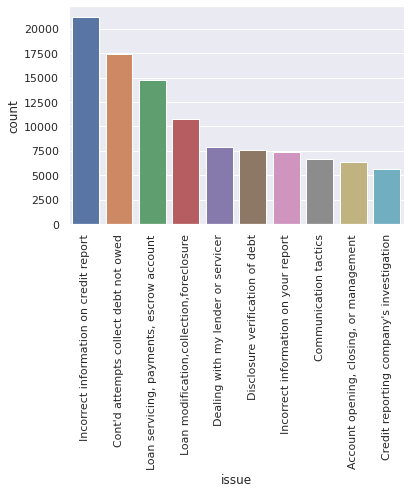

In [7]:
sns.barplot(data=issues_s, x='issue', y='count')
plt.xticks(rotation=90);

### Complaints per User

In [8]:
print('users with a single complaint:')
complaints_per_client_s = (
    x.groupBy('customer_name')
     .count()
     .sample(True, 0.1, seed=519753)
     .toPandas())

complaints_per_client_s.describe().T

users with a single complaint:


,count,mean,std,min,25%,50%,75%,max
count,11806.0,1.659156,1.827236,1.0,1.0,1.0,2.0,42.0


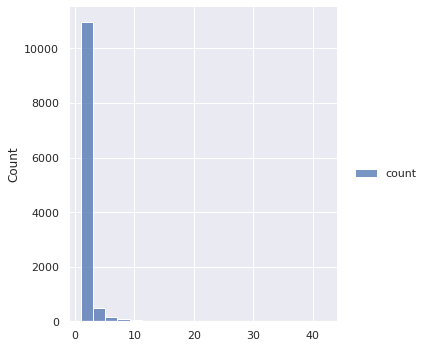

In [9]:
sns.displot(complaints_per_client_s, bins=20);

### Dates in Which Complaints Occurred

In [10]:
receiving_dates_s = (
    x.select('date_received')
     .sample(True, 0.1, seed=519753)
     .toPandas())

receiving_dates_s.describe().T

,count,unique,top,freq
date_received,19713,918,2017-01-19,101


/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


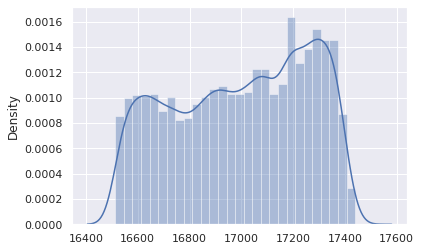

In [11]:
sns.distplot(receiving_dates_s.values.astype('datetime64'));

### Location

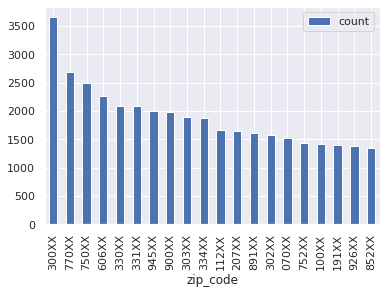

In [12]:
(x.where(x.zip_code.isNotNull())
  .groupBy('zip_code')
  .count()
  .orderBy(F.desc('count'))
  .limit(20)
  .toPandas()
  .set_index('zip_code')
  .plot(kind='bar'));